# 03. 분류
- - -

### 3.1 MNIST
MNIST 데이터 셋 : 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지 데이터 셋

In [1]:
import os
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**사이킷런의 데이터셋**
- 데이터셋을 설명하는 DESCR
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data
- 레이블 배열을 담은 target

In [3]:
X,y = mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

이미지 = 70,000개<br>
이지미의 특성 = 784개(왜냐하면 이미지가 28x28픽셀이므로)<br>
개개의 특성 = 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도<br>
<br>
데이터셋의 이미지 확인 = imshow 함수 사용, 샘플의 특성 벡터를 추출해서 28x28배열로 전환

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

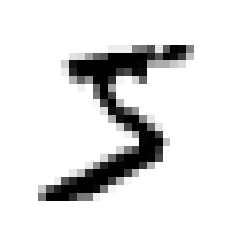

In [7]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [8]:
y[0] #실제 레이블

'5'

In [9]:
y = y.astype(np.uint8) #레이블이 문자열이므로 정수로 변환

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] #MINST 데이터셋은 이미 훈련 테스트로 나눠져있으므로

**데이터셋을 섞는 기준**<br>
훈련세트를 만들 때 모든 데이터가 고루 섞여있어서 모든 교차 검증 폴드를 비슷하게 만들어야 함<br>
심지어 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐<br>
그러므로 데이터셋을 섞어서 이런 현상 방지<br>
**but 시계열 데이터 같은 경우 이렇게 섞는 것은 좋지 않음**

### 3.2 이진 분류기 훈련
**이진 분류기(Binary classifier) = Yes or No 두개의 클래스 구분**<br>
이 챕터에서는 '5 감지기'가 목표 = 5 or not 5

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**- 사용할 분류 모델 : 사이킷런의 SGDClassifiter**<br>
<br>
**확률적 경사 하강법(Stochastic Gradient Descent, SGD)**<br>
매우 큰 데이터셋을 효율적으로 처리, 한 번에 하나씩 훈련 샘플을 독립적으로 처리 >> 온라인 학습에 잘 맞음<br>
확률적이라는 이름처럼 훈련할때 무작위성을 사용 >> 그러므로 random_state 매개변수를 지정해야함

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

predict로 감지했을 때 이 이미지가 5를 나타냇다고 추측

### 3.3 성능 측정<br>
### 3.3.1 교차 검증을 사용한 정확도 측정
사이킷런이 제공하는 것보다 더 많이 교차 검증 과정을 제어할 경우 교차 검증 기능 구현이 필요<br>
아래 코드는 사이킷런의 **cross_val_score()** 함수와 거의 같은 작업 수행

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5) :
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


**StratifiedKFold** = 계층적 샘플링 수행<br>
매 반복에서 분류기 객체를 복제하여 훈련폴드로 훈련시키고 테스트 폴드로 예측을 만듦<br>>> 올바른 예측의 수를 세어 정확한 예측의 비율 출력

**cross_val_scare()** 함수로 폴드가 3개인 KFold 교차 검증을 사용하여 **SGDClassifier** 모델 평가<br>
k=3이며, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델 사용

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

**'not 5'클래스로 분류하는 더미 분류기 만들기**

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator) :
    def fit(self, X, y=None) :
        return self
    def predict(self, X) :
        return np.zeros((len(X),1),dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

이 예제는 불균형한 데이터셋을 다룰때(어떤 클래스가 다른 것보다 월등히 많은 경우) 정확도를 분류기의 성능 측정 지표로 선호하지 않은 이유를 보여줌<br>
**5가 아님인 숫자가 90%** 이므로 정확도로 모델의 성능을 알 수 없음(10개중 9개가 원하는거니까 높은 성능으로 나옴)

### 3.3.2 오차 행렬
**오차 행렬(Confusion matrix)**<br>
클래스 A의 샘플를 클래스 B로 분류된 횟수를 세는 것<br>
예) 숫자 5의 이미지를 3으로 잘못 분류한 횟수 = 오차행렬의 5행 3열을 보면 됨<br>
- 오차 행렬의 행 = 실제 클래스<br>
- 오차 행렬의 열 = 예측한 클래스<br>

**cross_val_predict**으로 오차 행렬 작성 >> test세트로 확인<br>
- cross_val_predict : k겹 교차검증 진행 >> 각 테스트 폴드에서 얻은 예측 반환<br>
- cross_val_score : k겹 교차 검증 진행 >> 각 테스트 폴드의 예측을 평가 점수로 반환<br> 

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#confusion_matrix()함수로 오차행렬 만들기(타겟 클래스 = y_train_5, 예측 클래스 = y_train_pred)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

|분류|not 5|5|
|:-----:|:-----:|:-----:|
|**not 5**| 진짜 음성(TN)|거짓양성(FP)|
|**5**| 거짓 음성(FN)|진짜 양성(TP)|



**진짜 음성, Ture negative** = 'not 5'를 'not 5'(음성 클래스,negative class)로 분류된 것<br>
**거짓 양성, False positive** = 'not 5'를 '5'로 분류된 것<br>
**거짓 음성, False negative** = '5'를 'not 5'로 분류된 것<br>
**진짜 양성, Ture positive** = '5'를 '5'로 분류된 것<br>
- 완변한 분류기 = 주 대각선 값만 0이 아닌 값 = 주 대각선만 값, 나머지는 0

In [19]:
y_train_perfect_predictions= y_train_5 #완벽한 분류기인 경우
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

**정밀도(Precision)** = 양성 예측의 정확도<br>
<br>
$ 정밀도 =  \frac{TP}{TP+FP}$<br><br>
**재현율(민감도, 진짜 양성 비율,Recall,Sensitivity, True positive rate)** = 분류기가 정확하게 감지한 양성 샘플의 비율<br><br>
$ 재현율 =  \frac{TP}{TP+FN}$<br>

### 3.3.3 정밀도와 재현율

In [20]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

$F_1$**점수** = 정밀도와 재현율의 조화평균(Harmonic mean)<br><br>
$$F_1 = \frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}}=2\times{\frac{{정밀도}\times{재현율}}{{정밀도}+{재현율}}}=\frac{TP}{TP+\frac{FN+FP}{2}}$$<br>

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프
$F_1$점수의 정밀도와 재현율의 비율을 분석 목적에 맞게 조정하는 게 필요 = 정밀도/재현율 트레이드오프<br>
- 어린이용 동영상 분류기 = 좋은 동영상이 많이 제거(낮은 재현율)되더라도 안전한 것만 노출(높은 정밀도)<br>
- 카메라 이미지로 도둑 분류기 = 정밀도를 낮춰서라도 재현율 높여야함(잘못된 경비원 호출이 많더라도 좀도둑을 최대한 잡아야함)<br>

**SGDCLassifier** = **결정함수(Decision function)** 로 각 샘플의 점수를 계산<br>
점수가 임계값을 넘으면 양성, 낮으면 음성을 할당 >> sklearn에서 점수 직접 지정 불가<br>
->> 예측에 사용한 점수를 decision function으로 호출하여 점수 기반으로 임계값을 정해 예측을 만듦

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0 #임계값 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000 #임계값 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
#적절한 임계값 구하기
#1.훈련 세트에 있는 모든 샘플의 점수 구하기 >> 예측 결과x, 결정 점수를 반환받아야함
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")

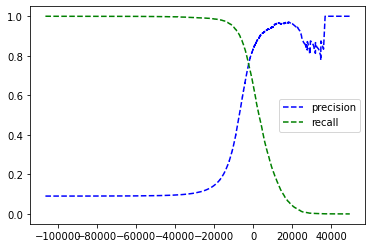

In [27]:
#2.precision_recall_curve()로 가능한 모든 임계값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#그래프로 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds) :
    plt.plot(thresholds, precisions[:-1],"b--",label='precision')
    plt.plot(thresholds, recalls[:-1], "g--", label='recall')
    plt.legend() #임계값을 표시하고 범례, 축이름, 그리드 추가
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

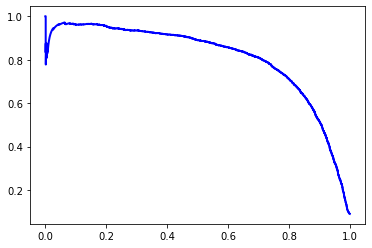

In [28]:
#좋은 트레이드 오프를 선택하려면 재현율에 대한 정밀도 곡선 그리기
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)

plot_precision_vs_recall(precisions, recalls)
plt.show()

재현율 80%부터 급격히 감소함을 알 수 있음 >> 이 하강점 직전을 트레이드오프로 선택하는 것이 좋음(프로젝트에 따라서 다름)

In [29]:
#If 정밀도 90% 달성이 목표일 때, 임계값 구하기
#np.argmax = 최대값의 첫번째 인덱스 반환 = 첫번째 ture 값 반환
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

#훈련세트에 대한 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)

#정밀도
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
#재현율
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선
**수신기 조작 특성(Receiver operating characteristic,ROC)**<br>
= 거짓 양성 비율(False positive rate,FPR)에 대한 진짜 양성 비율(Ture positive rate, TPR)의 곡선<br>
= 재현율(민감도)에 대한 1-특이도 그래프
- 거짓 양성 비율(FPR) =  1-진짜 음성 비율(특이도, Ture negative rate, TNR, Specificity)<br>
$$FPR = \frac{FP}{FP+TN} = \frac{FP+TN-TN}{FP+TN} = 1-\frac{TN}{FP+TN} = 1-TNR$$

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

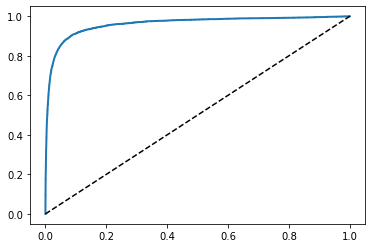

In [32]:
def plot_roc_curve(fpr, tpr, label = None) :
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--') #대각점선
    
plot_roc_curve(fpr,tpr)
plt.show()

**ROC 곡선의 트레이드오프**<br>
점섬 = 완전한 랜덤 분류기의 ROC 곡선 >> 좋은 분류기는 점섬에서 최대한 왼쪽으로 멀어야함<br>
재현율(TPR)니 높을수록 거짓양성(FPR) 상승<br>
**곡선 아래의 면적(area under the curve,AUC)** 측정으로 분류기 비교<br>
- ROC의 AUC = 1 : 완벽한 분류기
- ROC의 AUC = 0.5 : 완전한 랜덤 분류기(의미없는 완전한 랜덤 상태)

**PR곡선과 ROC곡선**
- PR곡선 = 양성 클래스가 드물거나, 거짓 음성보다 거짓 양성이 더 중요할 경우
- ROC곡선 = PR곡선과 반대<br>
= 5 or not 5의 경우 PR곡선이 분류기 성능판단에 더 적절함

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### **RandomForestClassifier**과 비교하기

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
#Randomforestclassifier은 decision_function 없고 predict_proba()사용
#predict_proba = 샘픔이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [35]:
y_scores_forest = y_probas_forest[:,1]#양성 클래스 확률을 점수로 활용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

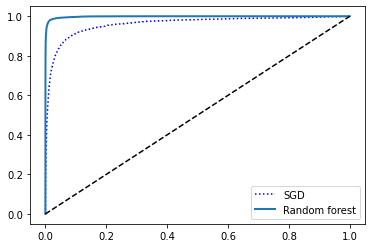

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,"Random forest")
plt.legend(loc = "lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

SGC보다 Randomforest가 더 나음 모델임을 확인 가능(ROC AUC 점수(0.96)도 더 높음)

### 3.4 다중 분류